### Python Script Description

C:\Users\naume\AppData\Local\Temp\ipykernel_38796\1631053281.py:41: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(output_path)  # Replace with your output CSV file


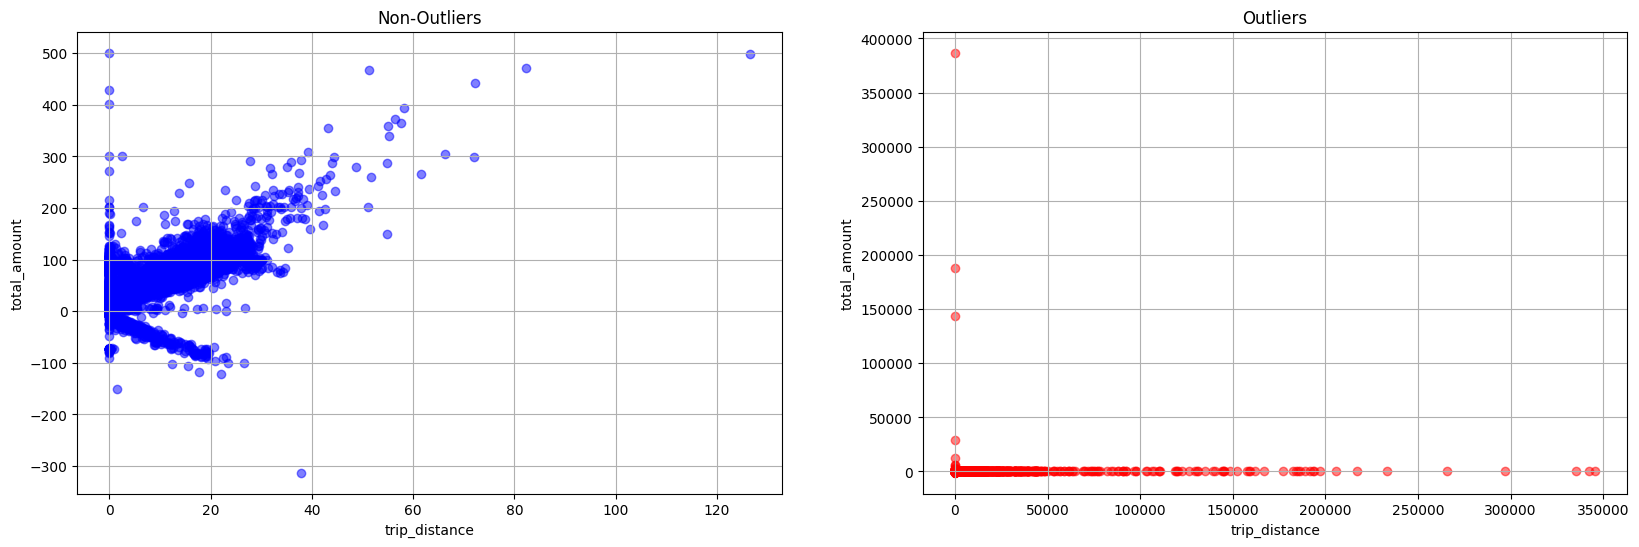

In [54]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def compute_label(frequency, threshold):
    return 'OUT' if frequency <= threshold else ''

def process_outliers(initial_csv_path, x_col_pos, y_col_pos, x_field, y_field, x_freq_table_path, y_freq_table_path, output_csv_path, threshold):
    initial_df = pd.read_csv(initial_csv_path, low_memory=False, usecols=[0, x_col_pos, y_col_pos], names=['index', x_field, y_field])
    
    # Convert columns to integers to match the frequency tables
    initial_df['x int value'] = initial_df[x_field].astype(int)
    initial_df['y int value'] = initial_df[y_field].astype(int)

    # Read the frequency tables for x and y columns
    x_freq_df = pd.read_csv(x_freq_table_path, delimiter='\t', names=['x int value', 'x freq'])
    y_freq_df = pd.read_csv(y_freq_table_path, delimiter='\t', names=['y int value', 'y freq'])

    # Compute the labels based on the threshold
    x_freq_df['label_x'] = x_freq_df['x freq'].apply(lambda freq: compute_label(freq, threshold))
    y_freq_df['label_y'] = y_freq_df['y freq'].apply(lambda freq: compute_label(freq, threshold))

    # Merge the initial data with the frequency tables on the x and y integer values
    merged_df = initial_df.merge(x_freq_df[['x int value', 'label_x']], how='left', on='x int value')
    merged_df = merged_df.merge(y_freq_df[['y int value', 'label_y']], how='left', on='y int value')

    # Create the 'label' column with 'OUT' if either x or y value is an outlier
    merged_df['label'] = merged_df.apply(
        lambda row: 'OUT' if row['label_x'] == 'OUT' or row['label_y'] == 'OUT' else '', axis=1
    )

    final_df = merged_df[['index', x_field, y_field, 'label']]

    # Save the final DataFrame to a CSV file
    final_df.to_csv(output_csv_path, index=False)

    print(f"Output CSV file created at: {output_csv_path}")

def plot_outliers(output_path, x_field, y_field):
    data = pd.read_csv(output_path)

    outliers = data[data['label'] == 'OUT']

    sample_size = 100000
    non_outliers = data[data['label'] != 'OUT'].sample(n=sample_size, random_state=1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

    # Plot non-outliers on the first subplot
    ax1.scatter(non_outliers[x_field], non_outliers[y_field], color='blue', alpha=0.5)
    ax1.set_title('Non-Outliers')
    ax1.set_xlabel(x_field)
    ax1.set_ylabel(y_field)
    ax1.grid(True)

    # Plot outliers on the second subplot
    ax2.scatter(outliers[x_field], outliers[y_field], color='red', alpha=0.5)
    ax2.set_title('Outliers')
    ax2.set_xlabel(x_field)
    ax2.set_ylabel(y_field)
    ax2.grid(True)
    plt.show()

input_path = './datasets/csv_datasets/combined_2023_data/part-00000-d6e687e9-decb-4d0a-9364-f1d3e23acf51-c000.csv'
directory_path = os.path.dirname(input_path)
file_name = os.path.basename(input_path)
no_header_input_path = f'{directory_path}\\NOHEADER_{file_name}'

initial_csv_path = no_header_input_path
x_freq_table_path="C:\\Users\\naume\\Desktop\\Licenta\\data-cleaning-services\\results\\avf_test_big_005\\x_e6c70c78-5335-4ea2-bb5d-4900019abdc3\\part-r-00000"
y_freq_table_path="C:\\Users\\naume\\Desktop\\Licenta\\data-cleaning-services\\results\\avf_test_big_005\\y_e6c70c78-5335-4ea2-bb5d-4900019abdc3\\part-r-00000"
output_csv_path = 'C:\\Users\\naume\\Desktop\\Licenta\\data-cleaning-services\\results\\avf_test_big_006\\labeled_result.csv'
threshold = 5
x_col_pos = 5
y_col_pos = 17
x_field = 'trip_distance'
y_field = 'total_amount'

# process_outliers(initial_csv_path, x_col_pos, y_col_pos, x_field, y_field, x_freq_table_path, y_freq_table_path, output_csv_path, threshold)
plot_outliers(output_csv_path, x_field, y_field)

In [13]:
import os
import sys
import subprocess
import re
import pandas as pd

def file_exists_in_directory(directory, filename):
    for existing_filename in os.listdir(directory):
        if existing_filename == filename:
            return True
    return False

input_path = './datasets/csv_datasets/combined_2023_data/part-00000-d6e687e9-decb-4d0a-9364-f1d3e23acf51-c000.csv'

# df = pd.read_csv(input_path, low_memory=False)

# df.head()

directory_path = os.path.dirname(input_path)
file_name = os.path.basename(input_path)

no_header_input_path = f'NOHEADER_{file_name}'

print(file_exists_in_directory(directory_path, no_header_input_path))

# df.to_csv(no_header_input_path, index=True, header=False)
df = pd.read_csv(input_path, nrows=0)
df.head()

x_column = df.columns.get_loc("trip_distance")
y_column = df.columns.get_loc("total_amount")

print(x_column)
print(y_column)

# trip_distance = 'trip_distance'

# print(f"The field number for the column is: {df.columns.get_loc(trip_distance)}")




./datasets/csv_datasets/combined_2023_data
NOHEADER_part-00000-d6e687e9-decb-4d0a-9364-f1d3e23acf51-c000.csv
True
4
16


In [1]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from IPython.display import display

# Initialize a Spark session
# local[*] = run local with as many threads as cores available
spark = SparkSession.builder \
    .config("spark.driver.host", "localhost") \
    .appName("Read Parquet File") \
    .master("local[*]") \
    .config("spark.executor.extraJavaOptions", "-XX:+UseG1GC -XX:InitiatingHeapOccupancyPercent=35") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.maxResultSize", "4g") \
    .config("spark.network.timeout", "1200s") \
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()

# Read the Parquet file
# parquet_file = "./datasets/combined_datasets/yellow_tripdata_2023.parquet" # too large apparently
parquet_file = "./datasets/filtered_fields_datasets/yellow_tripdata_2023_06_distance_amount.parquet"
df = spark.read.parquet(parquet_file).repartition(10).persist()

# Show the schema of the DataFrame
df.printSchema()

# Get the total number of records
total_records = df.count()

print(f"Total number of records: {total_records}")

# Convert to Pandas DataFrame for plotting
pdf = df.toPandas()

# Plot 1: All data
plt.figure(figsize=(10, 6))
plt.scatter(pdf['trip_distance'], pdf['total_amount'], alpha=0.5, color='blue')
plt.title('Trip Distance vs Total Amount (All Data)')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Total Amount ($)')
plt.grid(True)
plt.savefig('trip_distance_vs_total_amount_all_data.png')  # Save the plot as a PNG file
plt.close()  # Close the plot to free memory

# Calculate mean and standard deviation
mean_trip_distance = pdf['trip_distance'].mean()
std_trip_distance = pdf['trip_distance'].std()

mean_total_amount = pdf['total_amount'].mean()
std_total_amount = pdf['total_amount'].std()

# Filter data to include only values within 2 standard deviations from the mean
normalized_pdf = pdf[
    (pdf['trip_distance'] > mean_trip_distance - 2 * std_trip_distance) & 
    (pdf['trip_distance'] < mean_trip_distance + 2 * std_trip_distance) &
    (pdf['total_amount'] > mean_total_amount - 2 * std_total_amount) &
    (pdf['total_amount'] < mean_total_amount + 2 * std_total_amount)
]

# Plot 2: Normalized data
plt.figure(figsize=(10, 6))
plt.scatter(normalized_pdf['trip_distance'], normalized_pdf['total_amount'], alpha=0.5, color='green')
plt.title('Trip Distance vs Total Amount (Normalized Data)')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Total Amount ($)')
plt.grid(True)
plt.savefig('trip_distance_vs_total_amount_normalized_data.png')  # Save the plot as a PNG file
plt.close()  # Close the plot to free memory

spark.stop()

root
 |-- trip_distance: double (nullable = true)
 |-- total_amount: double (nullable = true)

Total number of records: 3307234
